# Predicting League of Legends Match Outcomes from Early Game Statistics

Aaron Wen (006484831)

A&O SCI C111: Introduction to Machine Learning for Physical Sciences

December 2025

## Abstract

This project applies supervised machine learning techniques to predict League of Legends match outcomes based solely on statistics captured at the 10-minute mark. Using a dataset of 9,879 Diamond-tier ranked games, I trained and evaluated six classification models: Logistic Regression (with L1 and L2 regularization), Decision Trees, Random Forests, Gradient Boosting, and Support Vector Machines. All models achieved approximately 72% test accuracy, with Logistic Regression (L1) performing best in cross-validation (73.5% ± 1.5%) and achieving an AUC of 0.80. Feature importance analysis reveals that gold difference is the strongest predictor of victory (r = 0.51), followed by experience difference (r = 0.49). Quantitative analysis shows that securing first blood increases win probability by 20 percentage points, while controlling both dragon and herald leads to a 73% win rate. These findings provide data-driven strategic recommendations for players seeking to optimize their early-game decision-making.

## 1. Introduction

League of Legends (LoL) is a multiplayer online battle arena (MOBA) game where two teams of five players compete to destroy the opposing team's base, known as the Nexus. Each match typically lasts 25-40 minutes and can be divided into three phases: the early game (0-15 minutes), mid game (15-25 minutes), and late game (25+ minutes). The early game, often called the "laning phase," is widely considered the foundation upon which victories are built.

During the laning phase, players focus on accumulating gold by killing enemy minions (small AI-controlled units that spawn periodically), securing kills against enemy champions (player-controlled characters), and taking neutral objectives like the Dragon (a powerful monster that grants team-wide buffs) and the Rift Herald (a monster that can be summoned to destroy enemy towers). The strategic decisions made during these critical first minutes—whether to play aggressively for kills, farm safely for gold, or rotate to help teammates—often determine the trajectory of the entire match.

Coaches and analysts in professional League of Legends frequently debate which early-game factors matter most. Some argue that securing First Blood (the first kill of the game, which grants bonus gold) provides crucial momentum, while others emphasize the importance of maintaining high CS (Creep Score, the number of minions killed) to ensure consistent gold income. This project addresses these questions through rigorous machine learning analysis.

The objectives of this study are threefold. First, I aim to build predictive models that can classify match winners using only statistics from the first 10 minutes. Second, I seek to identify which early-game factors most strongly influence victory through feature importance analysis. Third, I intend to provide quantitative strategic recommendations that players can use to optimize their early-game decision-making. By training models on nearly 10,000 high-level ranked games, this analysis moves beyond conventional wisdom to provide data-driven insights.

## 2. Data

### 2.1 Dataset Overview

The dataset used in this project is sourced from Kaggle and contains comprehensive statistics from 9,879 Diamond-tier ranked games, all captured at the 10-minute mark. Diamond tier represents approximately the top 2% of the player base and is normally seen as a benchmark between casual and professional players, which ensures that the data reflects skilled, competitive play rather than casual matches where fundamental mistakes might obscure strategic patterns. The choice of the 10-minute timestamp is significant because it captures the state of the game after the initial laning phase has developed but before major team objectives become available.

**Dataset Source:** [Kaggle - League of Legends Diamond Ranked Games 10 min](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc)

np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

df = pd.read_csv('high_diamond_ranked_10min.csv')
print(f"Dataset Shape: {df.shape[0]} games × {df.shape[1]} features")

print(f"\nMissing Values: {df.isnull().sum().sum()}")

blue_cols = [col for col in df.columns if col.startswith('blue')]
red_cols = [col for col in df.columns if col.startswith('red')]
print(f"\nBlue team features: {len(blue_cols)}")
print(f"Red team features: {len(red_cols)}")

Dataset Shape: 9879 games × 40 features

Missing Values: 0

Blue team features: 20
Red team features: 19


### 2.2 Feature Description

The dataset contains 40 columns in total, consisting of one game identifier, one target variable, and 19 features for each of the two teams (Blue and Red). The features can be organized into several categories based on the game mechanics they represent.

The **target variable** is `blueWins`, a binary indicator where 1 means the Blue team won and 0 means the Red team won. Since the dataset is structured from the Blue team's perspective, all "blue" prefixed features represent the Blue team's statistics, while "red" prefixed features represent their opponents.

The **combat statistics** include `blueKills` (the number of enemy champions killed by the Blue team), `blueDeaths` (the number of times Blue team members were killed), and `blueAssists` (the number of kills where a Blue team member contributed damage but did not get the final blow). These metrics directly reflect the team's success in player-versus-player combat. In League of Legends, each kill grants approximately 300 gold plus additional gold based on the victim's kill streak, making kills a significant source of income.

The **economic indicators** are perhaps the most important category. `blueTotalGold` represents the total gold accumulated by the Blue team, while `blueGoldDiff` calculates the difference between Blue and Red team gold (positive values favor Blue). Similarly, `blueTotalExperience` and `blueExperienceDiff` track experience points, which determine champion levels. Higher levels grant access to stronger abilities and increased base statistics, creating a compounding advantage.

The **farming statistics** measure how efficiently teams collect gold from minions. `blueTotalMinionsKilled` (also known as CS or Creep Score) counts lane minions killed, while `blueTotalJungleMinionsKilled` counts neutral jungle monsters. Professional players typically aim for 8-10 CS per minute, meaning approximately 80-100 minions killed by the 10-minute mark. `blueCSPerMin` and `blueGoldPerMin` provide rate-based versions of these metrics.

The **objective control** features track major neutral objectives. `blueDragons` counts the number of dragons slain (typically 0 or 1 at 10 minutes, since Dragon spawns at 5:00 and has a 5-minute respawn timer). `blueHeralds` counts Rift Herald captures (also typically 0 or 1, as Herald spawns at 8:00). `blueTowersDestroyed` counts enemy towers destroyed, and `blueFirstBlood` is a binary indicator for whether Blue team secured the first kill of the game.

The **vision control** features include `blueWardsPlaced` (the number of wards, which are items that reveal areas of the map from the dark, placed by Blue team) and `blueWardsDestroyed` (enemy wards destroyed). Vision control is crucial in high-level play for tracking enemy movements and setting up ambushes.

Finally, `blueEliteMonsters` is an aggregate count of major neutral objectives (Dragons + Heralds), and `blueAvgLevel` represents the average champion level across the five Blue team members.

In [2]:
print("All Features in Dataset:")
for i, col in enumerate(df.columns):
    print(f"{i+1:2d}. {col}")

All Features in Dataset:
 1. gameId
 2. blueWins
 3. blueWardsPlaced
 4. blueWardsDestroyed
 5. blueFirstBlood
 6. blueKills
 7. blueDeaths
 8. blueAssists
 9. blueEliteMonsters
10. blueDragons
11. blueHeralds
12. blueTowersDestroyed
13. blueTotalGold
14. blueAvgLevel
15. blueTotalExperience
16. blueTotalMinionsKilled
17. blueTotalJungleMinionsKilled
18. blueGoldDiff
19. blueExperienceDiff
20. blueCSPerMin
21. blueGoldPerMin
22. redWardsPlaced
23. redWardsDestroyed
24. redFirstBlood
25. redKills
26. redDeaths
27. redAssists
28. redEliteMonsters
29. redDragons
30. redHeralds
31. redTowersDestroyed
32. redTotalGold
33. redAvgLevel
34. redTotalExperience
35. redTotalMinionsKilled
36. redTotalJungleMinionsKilled
37. redGoldDiff
38. redExperienceDiff
39. redCSPerMin
40. redGoldPerMin


In [3]:
win_counts = df['blueWins'].value_counts()
print("Target Variable Distribution:")
print(f"  Blue Team Wins: {win_counts[1]:,} ({win_counts[1]/len(df)*100:.1f}%)")
print(f"  Red Team Wins:  {win_counts[0]:,} ({win_counts[0]/len(df)*100:.1f}%)")

Target Variable Distribution:
  Blue Team Wins: 4,930 (49.9%)
  Red Team Wins:  4,949 (50.1%)


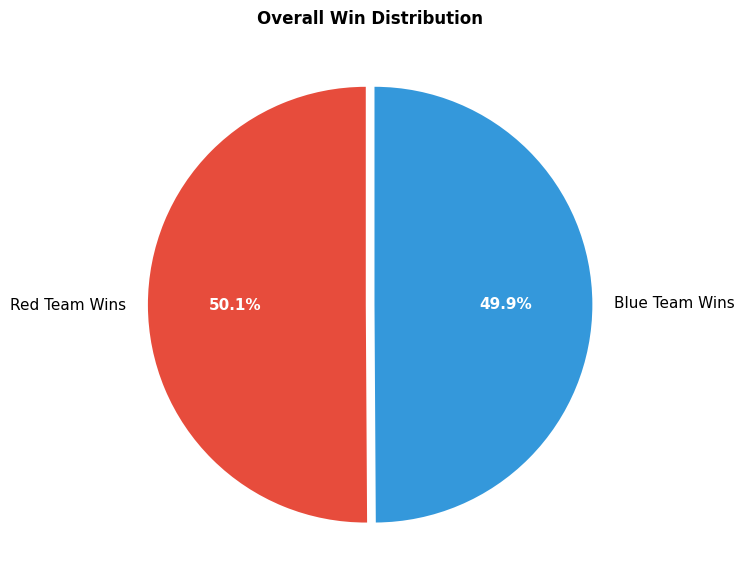

In [4]:
fig, ax1 = plt.subplots(figsize=(8, 6))
colors = ['#E74C3C', '#3498DB']
wedges, texts, autotexts = ax1.pie(
    [win_counts[0], win_counts[1]], 
    labels=['Red Team Wins', 'Blue Team Wins'],
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    explode=(0.02, 0.02)
)
ax1.set_title('Overall Win Distribution', fontweight='bold', fontsize=12)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.savefig('Overall Win Distribution', dpi=150, bbox_inches='tight')
plt.show()

The target variable distribution reveals a nearly perfectly balanced dataset, with Blue team winning 49.9% of games and Red team winning 50.1%. This balance is ideal for classification problems because it means we can use accuracy as a reliable performance metric without concerns about class imbalance. If, for example, one team won 90% of games, a naive classifier that always predicted that team would achieve 90% accuracy without learning anything meaningful. The balanced nature of this dataset ensures that our models must learn genuine patterns to perform well.

In [5]:
# Summary statistics for key features
key_features = ['blueKills', 'blueDeaths', 'blueGoldDiff', 'blueExperienceDiff', 
                'blueDragons', 'blueHeralds', 'blueFirstBlood']
df[key_features].describe().round(2)

,blueKills,blueDeaths,blueGoldDiff,blueExperienceDiff,blueDragons,blueHeralds,blueFirstBlood
count,9879.00,9879.00,9879.00,9879.00,9879.00,9879.00,9879.0
mean,6.18,6.14,14.41,-33.62,0.36,0.19,0.5
std,3.01,2.93,2453.35,1920.37,0.48,0.39,0.5
min,0.00,0.00,-10830.00,-9333.00,0.00,0.00,0.0
25%,4.00,4.00,-1585.50,-1290.50,0.00,0.00,0.0
50%,6.00,6.00,14.00,-28.00,0.00,0.00,1.0
75%,8.00,8.00,1596.00,1212.00,1.00,0.00,1.0
max,22.00,22.00,11467.00,8348.00,1.00,1.00,1.0


### 2.3 Exploratory Data Analysis

Before building predictive models, it is essential to understand the relationships between early-game statistics and match outcomes. This exploratory analysis will guide feature selection and provide initial hypotheses about which factors matter most.

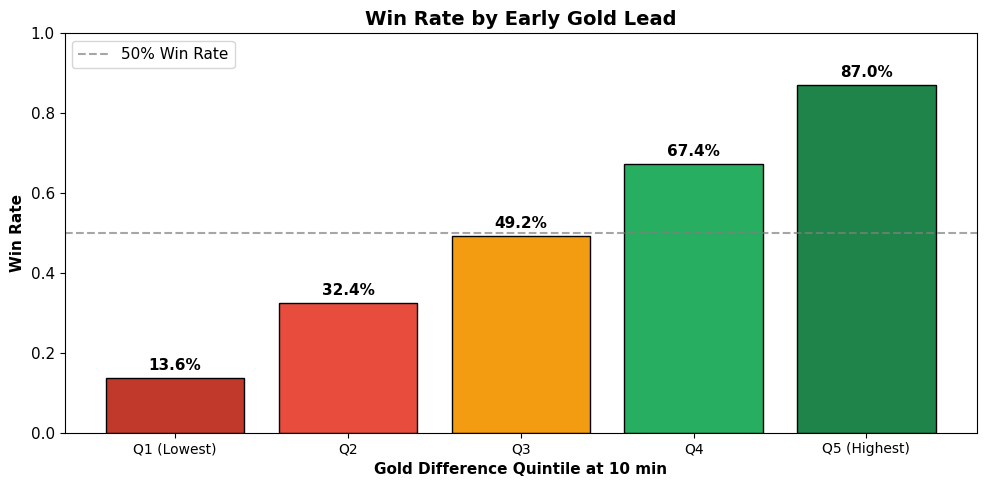

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))

df['goldQuintile'] = pd.qcut(df['blueGoldDiff'], q=5, 
                             labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)'])
win_rate_by_gold = df.groupby('goldQuintile', observed=True)['blueWins'].mean()

colors_gradient = ['#c0392b', '#e74c3c', '#f39c12', '#27ae60', '#1e8449']
bars = ax.bar(range(len(win_rate_by_gold)), win_rate_by_gold.values, 
              color=colors_gradient, edgecolor='black')

ax.set_xlabel('Gold Difference Quintile at 10 min', fontweight='bold')
ax.set_ylabel('Win Rate', fontweight='bold')
ax.set_title('Win Rate by Early Gold Lead', fontweight='bold', fontsize=14)
ax.set_xticks(range(len(win_rate_by_gold)))
ax.set_xticklabels(win_rate_by_gold.index, fontsize=10)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='50% Win Rate')
ax.set_ylim([0, 1])
ax.legend()

for bar, value in zip(bars, win_rate_by_gold.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{value:.1%}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('figure1_win_rate_by_gold.png', dpi=150, bbox_inches='tight')
plt.show()

df.drop('goldQuintile', axis=1, inplace=True)

The figure above reveals a striking relationship between gold advantage and win probability. The left panel confirms the balanced nature of the dataset, while the right panel demonstrates the predictive power of early gold leads. Teams in the lowest gold quintile at 10 minutes win only 13.6% of their games, while teams in the highest quintile win 87.0%. This 73.4 percentage point difference is remarkably large and suggests that gold advantage is one of the most important factors in determining match outcomes.

To put this in practical terms, consider a scenario where a team secures two early kills worth 600 gold total, plus maintains a 10 CS advantage (approximately 200 gold). This 800 gold lead might be enough to move a team from the middle quintile to the fourth quintile, increasing their expected win rate from about 49% to 67%. The compounding nature of advantages in League of Legends, where gold buys items that make it easier to earn more gold, explains why early leads translate so strongly into victories.

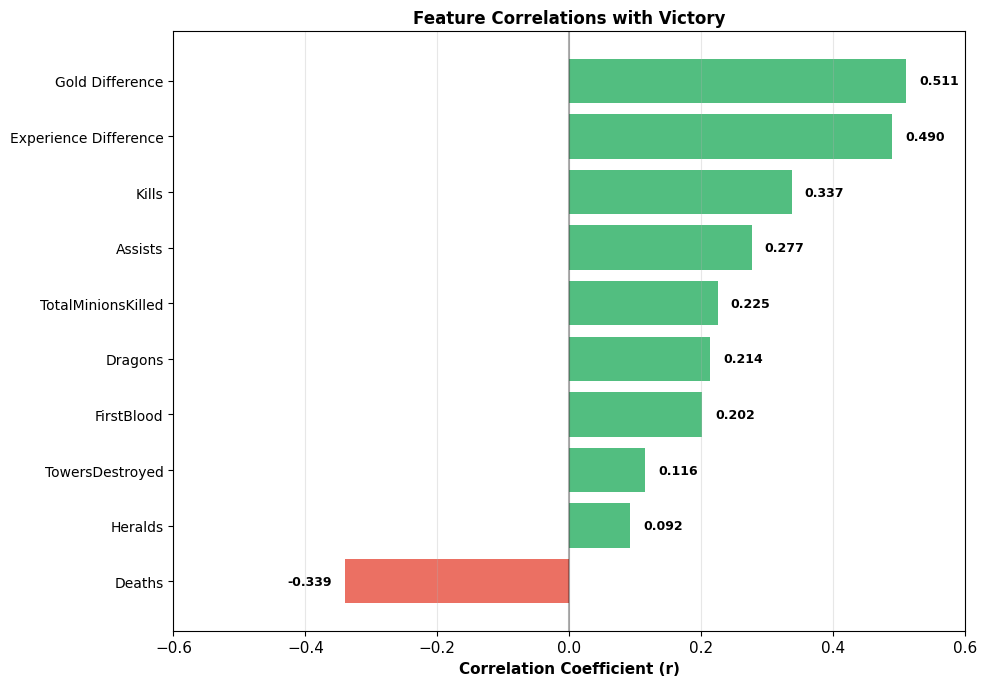

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))
feature_cols = ['blueGoldDiff', 'blueExperienceDiff', 'blueKills', 'blueDragons', 
                'blueFirstBlood', 'blueTowersDestroyed', 'blueHeralds', 
                'blueAssists', 'blueTotalMinionsKilled', 'blueDeaths']

correlations = df[feature_cols].corrwith(df['blueWins']).sort_values(ascending=True)

colors_corr = ['#E74C3C' if x < 0 else '#27AE60' for x in correlations.values]
bars = ax.barh(range(len(correlations)), correlations.values, color=colors_corr, alpha=0.8)

ax.set_yticks(range(len(correlations)))
ax.set_yticklabels([col.replace('blue', '').replace('Diff', ' Difference') 
                    for col in correlations.index], fontsize=10)
ax.set_xlabel('Correlation Coefficient (r)', fontweight='bold')
ax.set_title('Feature Correlations with Victory', fontweight='bold', fontsize=12)
ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax.set_xlim([-0.6, 0.6])
ax.grid(axis='x', alpha=0.3)

for bar, value in zip(bars, correlations.values):
    x_pos = value + (0.02 if value > 0 else -0.02)
    ax.text(x_pos, bar.get_y() + bar.get_height()/2,
            f'{value:.3f}', ha='left' if value > 0 else 'right',
            va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('figure2_feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

This figure presents the Pearson correlation coefficients between each feature and the binary win outcome. Gold Difference emerges as the strongest predictor with a correlation of 0.511, followed closely by Experience Difference at 0.490. These two metrics capture the fundamental resources in League of Legends: gold enables purchasing powerful items, while experience grants level advantages that increase a champion's base statistics and unlock stronger abilities.

The correlation for Kills (0.338) is notably lower than for Gold Difference, which reveals an important strategic insight. Kills are valuable primarily because they generate gold and experience, not because of their intrinsic value. A team that secures many kills but fails to convert them into gold advantages (by not farming effectively afterward or by dying themselves) may not see the expected benefit. This explains why professional coaches often emphasize "clean" kills that come without trading deaths, rather than aggressive plays that result in mutual exchanges.

Deaths show a strong negative correlation of -0.339, which is nearly symmetric with the positive correlation of Kills. This symmetry makes sense because in most cases, one team's kill is another team's death. However, the slight difference suggests that avoiding deaths may be marginally more important than securing kills, supporting the common advice to "play safe" when behind.

Dragon control shows a correlation of 0.212, which is meaningful but not overwhelming. In the context of League of Legends, Dragon provides team-wide buffs and gold, but the first dragon typically spawns at 5:00 and takes about 30 seconds to kill. At the 10-minute mark, most games have seen at most one dragon taken, limiting the variance in this feature. First Blood, the first kill of the game worth bonus gold, shows a similar correlation of 0.202, confirming its strategic importance without being deterministic. This is reasonable since First Blood only provides 400 gold, only 100 gold more than a standard kill, and thus its impact is limited compared to sustained gold advantages.

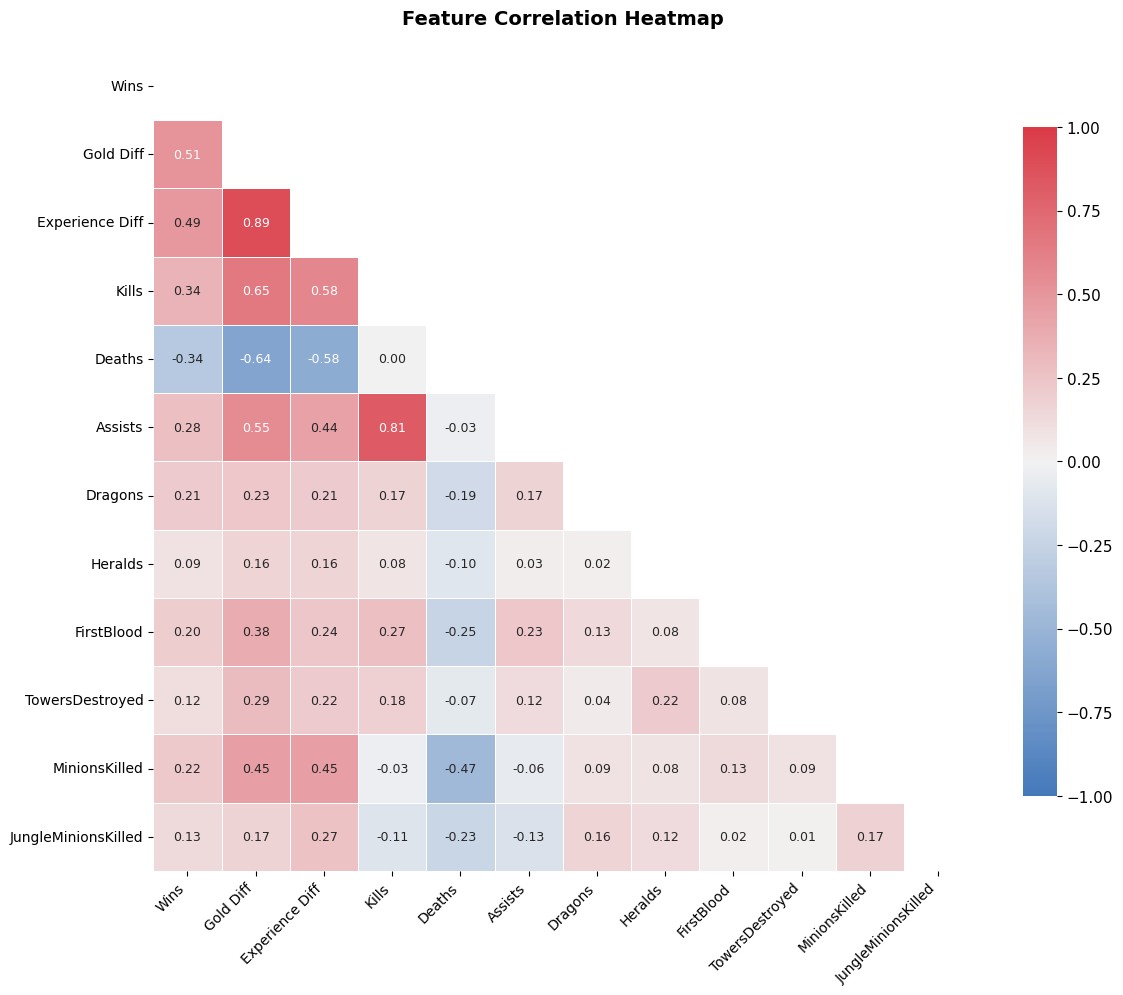

In [ ]:
heatmap_features = ['blueWins', 'blueGoldDiff', 'blueExperienceDiff', 'blueKills', 'blueDeaths',
                    'blueAssists', 'blueDragons', 'blueHeralds', 'blueFirstBlood', 
                    'blueTowersDestroyed', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled']
corr_matrix = df[heatmap_features].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(250, 10, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot=True, fmt='.2f', annot_kws={"size": 9}, ax=ax)

ax.set_title('Feature Correlation Heatmap', fontweight='bold', fontsize=14, pad=20)

# Clean up labels
labels = [col.replace('blue', '').replace('Total', '').replace('Diff', ' Diff') for col in heatmap_features]
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(labels, rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig('figure2b_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

The figure above presents a correlation heatmap that reveals the relationships between all features simultaneously. Several patterns emerge from this visualization.

First, Gold Difference and Experience Difference are highly correlated with each other (r = 0.89), which makes intuitive sense. Teams that are ahead in gold typically have more kills and farm, both of which also grant experience. This high correlation suggests potential multicollinearity, though both features are retained because they capture slightly different aspects of team advantage.

Second, Kills and Assists show a very strong positive correlation (r = 0.81), reflecting that team fights generate both statistics simultaneously. Kills also correlate strongly with Gold Difference (r = 0.65) and Experience Difference (r = 0.58), confirming that combat success translates directly into resource advantages. Conversely, Deaths show strong negative correlations with both Gold Difference (r = -0.64) and Experience Difference (r = -0.58), highlighting how dying sets teams behind in multiple dimensions.

Third, an interesting pattern emerges with MinionsKilled (CS): it correlates negatively with Deaths (r = -0.47), suggesting that players who die frequently also miss farm opportunities. This creates a double penalty that compounds their disadvantage. MinionsKilled also shows moderate positive correlations with Gold Difference (r = 0.45) and Experience Difference (r = 0.45), reinforcing the importance of consistent farming.

Last, First Blood shows moderate correlations with Gold Difference (r = 0.38) and Kills (r = 0.27), but weaker correlations with other features, indicating it captures unique early-game information not fully redundant with other combat statistics. Dragons and Heralds show relatively weak correlations with each other (r = 0.02), suggesting that securing one objective does not necessarily predict securing the other. Teams may prioritize different sides of the map based on their composition and game state.

## 3. Methods

### 3.1 Feature Engineering

Beyond the raw features provided in the dataset, this research created several derived features that capture strategic concepts not directly measured. These engineered features combine multiple raw statistics to represent higher-level game states that experienced players would recognize as important.

In [9]:
df_model = df.copy()

# KDA
df_model['blueKDRatio'] = df_model['blueKills'] / (df_model['blueDeaths'] + 1)

# dragon + herald score
df_model['blueObjectiveControl'] = df_model['blueDragons'] + df_model['blueHeralds']

# CS diff
df_model['blueCSDiff'] = df_model['blueTotalMinionsKilled'] - df_model['redTotalMinionsKilled']

print("Engineered Features Created:")
print("  - blueKDRatio")
print("  - blueObjectiveControl")
print("  - blueCSDiff")

Engineered Features Created:
  - blueKDRatio
  - blueObjectiveControl
  - blueCSDiff


The KD Ratio (Kill-to-Death Ratio) is calculated as kills divided by deaths plus one, where the addition of one prevents division by zero for players with no deaths. This metric captures combat efficiency in a way that neither kills nor deaths alone can express. A team with 5 kills and 2 deaths has a KD ratio of 1.67, indicating they are winning fights, while a team with 5 kills and 8 deaths has a ratio of 0.56, indicating they are losing trades even though they have secured some kills. In practical gameplay, a high KD ratio often reflects better positioning, coordination, and decision-making in fights.

The Objective Control score simply sums the number of dragons and heralds secured. While the dataset already contains these features separately, combining them makes conceptual sense because both represent successful neutral objective takes. A team that has secured both a dragon and a herald has demonstrated map control and the ability to coordinate around major objectives, which typically requires winning nearby fights or gaining vision advantages.

The CS Difference measures the gap in minion kills between the two teams. Unlike Gold Difference, which combines all sources of income, CS Difference specifically captures lane performance. A positive CS Difference indicates that the team is winning the farming battle, successfully last-hitting minions while potentially denying the enemy through pressure or kills. 


In a typical game, each minion is worth approximately 20 gold, so a 20 CS advantage translates to roughly 400 gold. This metric reflects deeper aspects of lane control beyond simple gold accumulation. In the early game, minions deal substantial damage that can determine trade outcomes, as a full minion wave at level 1 can output more damage than a champion. Players who maintain CS advantages typically have better wave control, allowing them to build large waves that crash into enemy towers. This creates windows for roaming to objectives or other lanes while opponents are forced to farm under tower. A consistent CS lead therefore indicates not just mechanical proficiency in last-hitting, but also superior understanding of wave manipulation and lane priority, both of which translate into map-wide advantages.

### 3.2 Feature Selection

From the available features, I selected 14 for inclusion in the final model. This selection was guided by several principles: avoiding redundancy between highly correlated features, ensuring each feature has clear strategic meaning, and including both raw statistics and engineered features.

In [ ]:
selected_features = [
    # Combat statistics
    'blueKills', 'blueDeaths', 'blueAssists',
    # Economic differences
    'blueGoldDiff', 'blueExperienceDiff',
    # Objective control
    'blueDragons', 'blueHeralds', 'blueFirstBlood', 'blueTowersDestroyed',
    # Engineered features
    'blueKDRatio', 'blueObjectiveControl', 'blueCSDiff',
    # Farming statistics
    'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled',
]

X = df_model[selected_features].copy()
y = df_model['blueWins'].copy()
print(f"Feature Matrix: {X.shape[0]} samples × {X.shape[1]} features")

Feature Matrix: 9879 samples × 14 features


The selection of these 14 features reflects careful consideration of both statistical properties and game knowledge. I included Gold Difference and Experience Difference because they are the strongest predictors based on correlation analysis, capturing the fundamental resource advantages that determine which team can afford better items and has access to stronger abilities. Kills, Deaths, and Assists are included because they represent direct combat outcomes, though as discussed earlier, their value lies primarily in the gold and experience they generate.

I chose to include Dragon, Herald, First Blood, and Towers Destroyed as separate features rather than aggregating them because they represent distinct strategic choices. Taking Dragon requires coordination with the bottom lane and jungle, while Herald is a top-side objective. A team might secure Dragon but lose Herald, and this information would be lost in a simple aggregate. The engineered features (KD Ratio, Objective Control, CS Difference) provide additional perspectives that combine raw statistics in strategically meaningful ways.

I deliberately excluded several features to avoid redundancy and multicollinearity. Total Gold was excluded because Gold Difference captures the same information relative to the opponent and showed higher correlation with winning. Wards Placed and Wards Destroyed were excluded because they showed very low correlation with match outcomes in preliminary analysis, possibly because vision control affects outcomes through other mechanisms (enabling kills, preventing deaths) that are already captured. Average Level was excluded because it is highly correlated with Experience Difference, and the difference form is more predictive. Finally, Gold Per Minute and CS Per Minute were excluded because they are deterministic functions of Total Gold and Total Minions Killed given the fixed 10-minute timestamp.

### 3.3 Data Preprocessing

The data is split into training and test sets using an 80-20 ratio, with stratification to ensure both sets maintain the same class distribution. Feature standardization is then applied to the training set and used to transform both sets.

In [ ]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training Set: {X_train.shape[0]} samples (Win Rate: {y_train.mean():.2%})")
print(f"Test Set:     {X_test.shape[0]} samples (Win Rate: {y_test.mean():.2%})")

# Feature standardization
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=selected_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=selected_features)

Training Set: 7903 samples (Win Rate: 49.91%)
Test Set:     1976 samples (Win Rate: 49.90%)


Stratification in the train-test split ensures that both the training and test sets have approximately 50% win rates, matching the overall dataset distribution. This is important because if the split happened to put most wins in the training set, the model might overfit to that distribution and perform poorly on the differently-distributed test set.

Feature standardization transforms each feature to have zero mean and unit variance. This preprocessing step is essential for algorithms like Logistic Regression and Support Vector Machines, where the optimization process is sensitive to feature scales. For example, Gold Difference might range from -10,000 to +10,000, while First Blood is always 0 or 1. Without standardization, the larger-magnitude features would dominate the optimization. Tree-based methods like Decision Trees and Random Forests are invariant to feature scaling, but standardizing does not harm their performance and allows consistent preprocessing across all models.

### 3.4 Models

I implemented six classification models representing different machine learning paradigms. Each model has distinct strengths and makes different assumptions about the data, allowing us to assess which approach best captures the patterns in early-game statistics.

In [12]:
# Evaluation function
def evaluate_model(model, X_tr, X_te, y_tr, y_te):
    """Calculate comprehensive metrics for model evaluation."""
    y_train_pred = model.predict(X_tr)
    y_test_pred = model.predict(X_te)
    return {
        'train_acc': accuracy_score(y_tr, y_train_pred),
        'test_acc': accuracy_score(y_te, y_test_pred),
        'precision': precision_score(y_te, y_test_pred),
        'recall': recall_score(y_te, y_test_pred),
        'f1': f1_score(y_te, y_test_pred)
    }

results = {}

#### 3.4.1 Logistic Regression

Logistic Regression is a linear classification algorithm that models the probability of the positive class using the sigmoid function. For a feature vector $x$, the predicted probability is given by:

$$P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + ... + \beta_n x_n)}}$$

The model parameters $\beta$ are learned by maximizing the likelihood of the observed data, with an L2 regularization term added to prevent overfitting. L2 regularization penalizes large coefficient values, encouraging the model to find solutions where no single feature dominates the prediction.

In [13]:
# Model 1 logistic with L2
log_reg = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
results['Logistic Regression'] = evaluate_model(log_reg, X_train_scaled, X_test_scaled, y_train, y_test)

print("Logistic Regression (L2):")
print(f"  Train Accuracy: {results['Logistic Regression']['train_acc']:.4f}")
print(f"  Test Accuracy:  {results['Logistic Regression']['test_acc']:.4f}")

Logistic Regression (L2):
  Train Accuracy: 0.7359
  Test Accuracy:  0.7242


#### 3.4.2 Logistic Regression with L1 Regularization (Lasso)

L1 regularization differs from L2 by penalizing the absolute value of coefficients rather than their squares. This has the important property of driving some coefficients exactly to zero, effectively performing automatic feature selection. Features with zero coefficients are excluded from the model entirely, which can improve interpretability and sometimes generalization.

In [14]:
# lasso
log_reg_l1 = LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=1000, random_state=42)
log_reg_l1.fit(X_train_scaled, y_train)
results['Logistic Regression (L1)'] = evaluate_model(log_reg_l1, X_train_scaled, X_test_scaled, y_train, y_test)

print("Logistic Regression (L1):")
print(f"  Train Accuracy: {results['Logistic Regression (L1)']['train_acc']:.4f}")
print(f"  Test Accuracy:  {results['Logistic Regression (L1)']['test_acc']:.4f}")

l1_coefs = pd.Series(log_reg_l1.coef_[0], index=selected_features)
n_selected = (l1_coefs != 0).sum()
print(f"  Features selected: {n_selected}/{len(selected_features)}")

Logistic Regression (L1):
  Train Accuracy: 0.7362
  Test Accuracy:  0.7242
  Features selected: 13/14


#### 3.4.3 Decision Tree

Decision Trees learn a series of if-then rules that recursively partition the feature space. At each node, the algorithm selects the feature and threshold that best separates the classes, using GINI impurity as the splitting criterion:

$$\text{GINI} = 1 - \sum_{i=1}^{C} p_i^2$$

where $p_i$​ is the proportion of samples belonging to class $i$. A GINI value of 0 means a pure node where all samples belong to one class, while 0.5 indicates maximum uncertainty in a binary classification setting. The tree grows by repeatedly choosing splits that produce the purest possible child nodes.

In [15]:
#Decision Tree
decision_tree = DecisionTreeClassifier(
    criterion='gini', max_depth=5, min_samples_split=50, min_samples_leaf=20, random_state=42
)
decision_tree.fit(X_train, y_train)
results['Decision Tree'] = evaluate_model(decision_tree, X_train, X_test, y_train, y_test)

print("Decision Tree:")
print(f"  Train Accuracy: {results['Decision Tree']['train_acc']:.4f}")
print(f"  Test Accuracy:  {results['Decision Tree']['test_acc']:.4f}")

Decision Tree:
  Train Accuracy: 0.7378
  Test Accuracy:  0.7196


The hyperparameters were chosen to prevent overfitting. Setting maximum depth to 5 limits how deep the tree can grow, stopping it from memorizing training data. The minimum samples per split (50) and per leaf (20) ensure that decisions are based on enough observations rather than noise.

#### 3.4.4 Random Forest

Random Forest builds multiple decision trees and combines their predictions through majority voting. Each tree is trained on a random sample of the data and considers only a random subset of features at each split. This randomness makes the individual trees different from each other, and averaging their predictions reduces overfitting compared to a single decision tree.

In [16]:
# Random Forest
random_forest = RandomForestClassifier(
    n_estimators=100, criterion='gini', max_depth=10, 
    min_samples_split=20, min_samples_leaf=10, random_state=42, n_jobs=-1
)
random_forest.fit(X_train, y_train)
results['Random Forest'] = evaluate_model(random_forest, X_train, X_test, y_train, y_test)

print("Random Forest:")
print(f"  Train Accuracy: {results['Random Forest']['train_acc']:.4f}")
print(f"  Test Accuracy:  {results['Random Forest']['test_acc']:.4f}")

Random Forest:
  Train Accuracy: 0.7884
  Test Accuracy:  0.7201


#### 3.4.5 Gradient Boosting

Gradient Boosting builds an ensemble of decision trees sequentially, where each new tree attempts to correct the errors made by the previous trees. Unlike Random Forest which trains trees independently, Gradient Boosting uses a gradient descent approach to minimize a loss function. The learning rate parameter controls how much each tree contributes to the final prediction, trading off between accuracy and overfitting.

In [17]:
# Gradient Boosting
gradient_boosting = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3,
    min_samples_split=20, min_samples_leaf=10, random_state=42
)
gradient_boosting.fit(X_train, y_train)
results['Gradient Boosting'] = evaluate_model(gradient_boosting, X_train, X_test, y_train, y_test)

print("Gradient Boosting:")
print(f"  Train Accuracy: {results['Gradient Boosting']['train_acc']:.4f}")
print(f"  Test Accuracy:  {results['Gradient Boosting']['test_acc']:.4f}")

Gradient Boosting:
  Train Accuracy: 0.7495
  Test Accuracy:  0.7176


#### 3.4.6 Support Vector Machine (SVM)

Support Vector Machines find the optimal boundary that separates the two classes with the largest possible margin. When data cannot be separated by a straight line, the RBF (Radial Basis Function) kernel transforms the data into a higher-dimensional space where linear separation becomes possible:

$$K(x, x') = \exp\left(-\gamma ||x - x'||^2\right)$$

The kernel measures how similar two data points are, with $\gamma$ controlling how quickly similarity drops as points get farther apart.

In [18]:
# SVM with RBF kernel
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)  # SVM needs scaling
results['SVM (RBF)'] = evaluate_model(svm_model, X_train_scaled, X_test_scaled, y_train, y_test)

print("SVM (RBF Kernel):")
print(f"  Train Accuracy: {results['SVM (RBF)']['train_acc']:.4f}")
print(f"  Test Accuracy:  {results['SVM (RBF)']['test_acc']:.4f}")

SVM (RBF Kernel):
  Train Accuracy: 0.7420
  Test Accuracy:  0.7176


### 3.5 Cross-Validation

To obtain robust performance estimates that are less sensitive to the particular train-test split, I apply 5-fold stratified cross-validation. This procedure divides the training data into 5 equal parts, trains the model on 4 parts, evaluates on the remaining part, and repeats this process 5 times with different held-out folds. The result is 5 accuracy estimates, from which we compute the mean and standard deviation.

In [19]:
# cv-5
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_cv = {
    'Logistic Regression': (LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000, random_state=42), True),
    'Logistic Reg (L1)': (LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=1000, random_state=42), True),
    'Decision Tree': (DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=50, random_state=42), False),
    'Random Forest': (RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=20, random_state=42, n_jobs=-1), False),
    'Gradient Boosting': (GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42), False),
    'SVM (RBF)': (SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42), True)
}

cv_results = {}
print("Cross-Validation Results (5-Fold):")

for name, (model, needs_scaling) in models_cv.items():
    X_cv = X_train_scaled if needs_scaling else X_train
    scores = cross_val_score(model, X_cv, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_results[name] = {'mean': scores.mean(), 'std': scores.std()}
    print(f"  {name:22s}: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-Validation Results (5-Fold):
  Logistic Regression   : 0.7341 ± 0.0156
  Logistic Reg (L1)     : 0.7347 ± 0.0152
  Decision Tree         : 0.7131 ± 0.0082
  Random Forest         : 0.7291 ± 0.0131
  Gradient Boosting     : 0.7326 ± 0.0120
  SVM (RBF)             : 0.7269 ± 0.0117


This indicate that the Logistic Regression with L1 regularization performs best on average, achieving 73.5% accuracy with a standard deviation of 1.5%. This suggests that the model generalizes well across different subsets of the data, and the low standard deviation indicates consistent performance.

### 3.6 Hyperparameter Tuning

To understand how model performance depends on hyperparameter choices, I conduct experiments varying key hyperparameters for Random Forest and Gradient Boosting. This analysis helps identify optimal settings and reveals the bias-variance tradeoff inherent in each model.

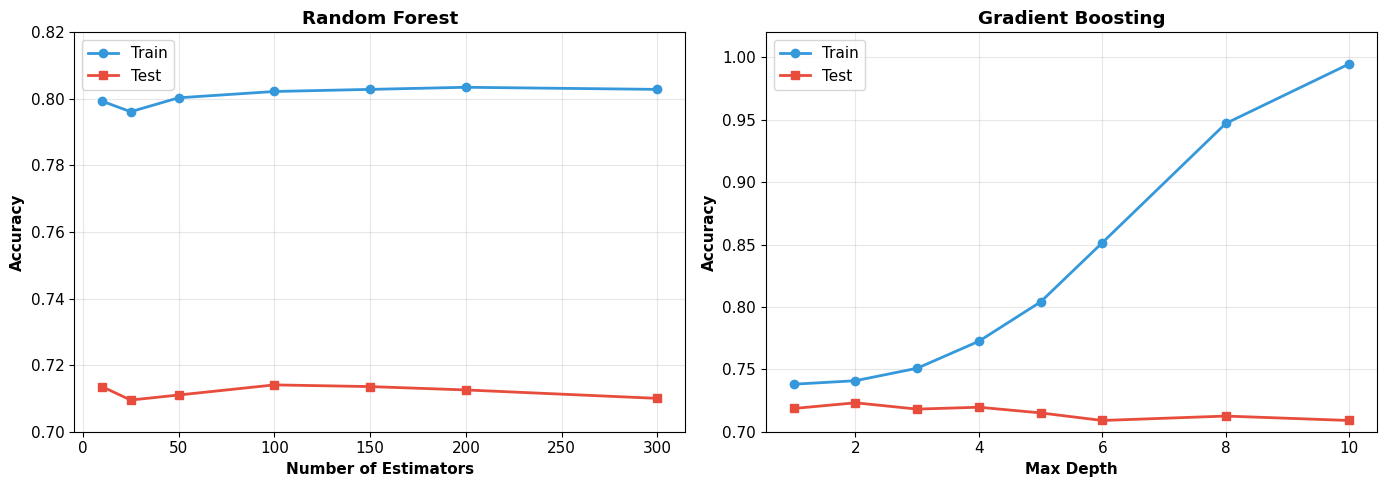

In [20]:
# Hyperparameter Tuning Experiments
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
n_estimators_range = [10, 25, 50, 100, 150, 200, 300]
rf_train_scores = []
rf_test_scores = []

for n_est in n_estimators_range:
    rf_temp = RandomForestClassifier(n_estimators=n_est, max_depth=10, 
                                      min_samples_split=20, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train, y_train)
    rf_train_scores.append(accuracy_score(y_train, rf_temp.predict(X_train)))
    rf_test_scores.append(accuracy_score(y_test, rf_temp.predict(X_test)))

ax1 = axes[0]
ax1.plot(n_estimators_range, rf_train_scores, 'o-', label='Train', color='#3498DB', linewidth=2)
ax1.plot(n_estimators_range, rf_test_scores, 's-', label='Test', color='#E74C3C', linewidth=2)
ax1.set_xlabel('Number of Estimators', fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Random Forest', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_ylim([0.70, 0.82])

max_depth_range = [1, 2, 3, 4, 5, 6, 8, 10]
gb_train_scores = []
gb_test_scores = []

for depth in max_depth_range:
    gb_temp = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                          max_depth=depth, random_state=42)
    gb_temp.fit(X_train, y_train)
    gb_train_scores.append(accuracy_score(y_train, gb_temp.predict(X_train)))
    gb_test_scores.append(accuracy_score(y_test, gb_temp.predict(X_test)))

ax2 = axes[1]
ax2.plot(max_depth_range, gb_train_scores, 'o-', label='Train', color='#3498DB', linewidth=2)
ax2.plot(max_depth_range, gb_test_scores, 's-', label='Test', color='#E74C3C', linewidth=2)
ax2.set_xlabel('Max Depth', fontweight='bold')
ax2.set_ylabel('Accuracy', fontweight='bold')
ax2.set_title('Gradient Boosting', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_ylim([0.70, 1.02])

plt.tight_layout()
plt.savefig('figure3_hyperparameter_tuning.png', dpi=150, bbox_inches='tight')
plt.show()

The hyperparameter tuning experiments reveal important insights about model behavior. For Random Forest, increasing the number of estimators beyond 50 provides diminishing returns. The test accuracy plateaus while training accuracy continues to rise slightly, suggesting that 100 estimators is a reasonable choice that balances accuracy with computational cost.

For Gradient Boosting, the max_depth parameter shows a classic overfitting pattern. At max_depth=2, both training and test accuracy are similar (around 72-74%), indicating the model is too simple. As max_depth increases, training accuracy rises rapidly and reaches nearly 99% at depth=10, but test accuracy peaks around depth=3-4 and then declines. This demonstrates the bias-variance tradeoff: shallow trees underfit while deep trees overfit. The optimal depth of 3 balances these competing concerns.

## 4. Results

### 4.1 Model Performance Comparison

In [21]:
# summary
results_df = pd.DataFrame(results).T
results_df.columns = ['Train Acc', 'Test Acc', 'Precision', 'Recall', 'F1']
results_df.round(4)

,Train Acc,Test Acc,Precision,Recall,F1
Logistic Regression,0.7359,0.7242,0.7198,0.7323,0.7260
Logistic Regression (L1),0.7362,0.7242,0.7190,0.7343,0.7265
Decision Tree,0.7378,0.7196,0.7333,0.6886,0.7103
Random Forest,0.7884,0.7201,0.7194,0.7201,0.7197
Gradient Boosting,0.7495,0.7176,0.7179,0.7150,0.7165
SVM (RBF),0.7420,0.7176,0.7206,0.7089,0.7147


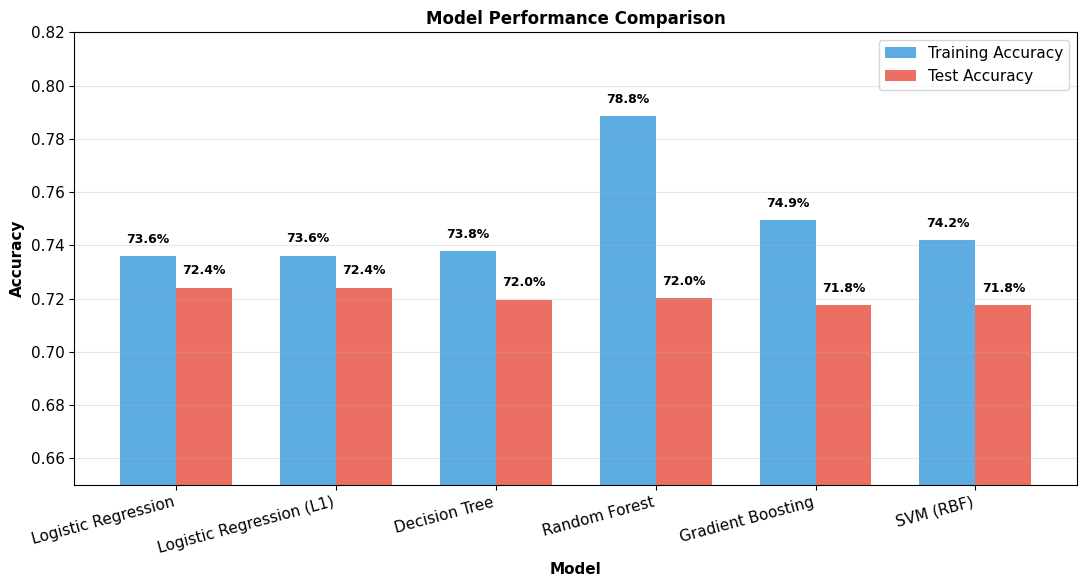

In [22]:
# Model compare
fig, ax = plt.subplots(figsize=(11, 6))

models = list(results.keys())
x = np.arange(len(models))
width = 0.35

train_accs = [results[m]['train_acc'] for m in models]
test_accs = [results[m]['test_acc'] for m in models]
bars1 = ax.bar(x - width/2, train_accs, width, label='Training Accuracy', color='#3498DB', alpha=0.8)
bars2 = ax.bar(x + width/2, test_accs, width, label='Test Accuracy', color='#E74C3C', alpha=0.8)

ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.set_ylim([0.65, 0.82])
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
            f'{bar.get_height():.1%}', ha='center', fontsize=9, fontweight='bold')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
            f'{bar.get_height():.1%}', ha='center', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.savefig('figure4_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

Figure 3 compares training and test accuracy across all six models, revealing several important patterns. All models achieve approximately 72% test accuracy, suggesting this may represent an approximate ceiling for prediction using only 10-minute statistics. The consistency across fundamentally different algorithms, from linear models to tree ensembles to kernel methods, indicates that the remaining 28% of matches are determined by factors not captured in these early-game features, such as champion compositions, individual player skill, or strategic decisions made after the 10-minute mark.

The Logistic Regression models demonstrate excellent generalization, with only a 1.2% gap between training and test accuracy. This small gap indicates that the linear decision boundary is well-suited to this problem, and the regularization is effectively preventing overfitting. Decision Tree shows a similar small gap of 1.8%, benefiting from the depth and sample constraints that prevent it from memorizing the training data.

In contrast, Random Forest shows signs of overfitting with a 6.8% gap between training and test accuracy, meaning it has learned some patterns in the training data that do not generalize to new games. Gradient Boosting shows moderate overfitting with a 3.3% gap, while SVM falls in between with a 2.4% gap. Despite these differences in overfitting behavior, all models converge to similar test accuracy around 72%.

The cross-validation results confirm Logistic Regression with L1 regularization as the best-performing model, achieving 73.5% accuracy with a standard deviation of only 1.5%. This tight standard deviation indicates stable performance across different subsets of the data, which is a desirable property for a model that will be applied to new, unseen games.

### 4.2 ROC Curves and AUC Analysis

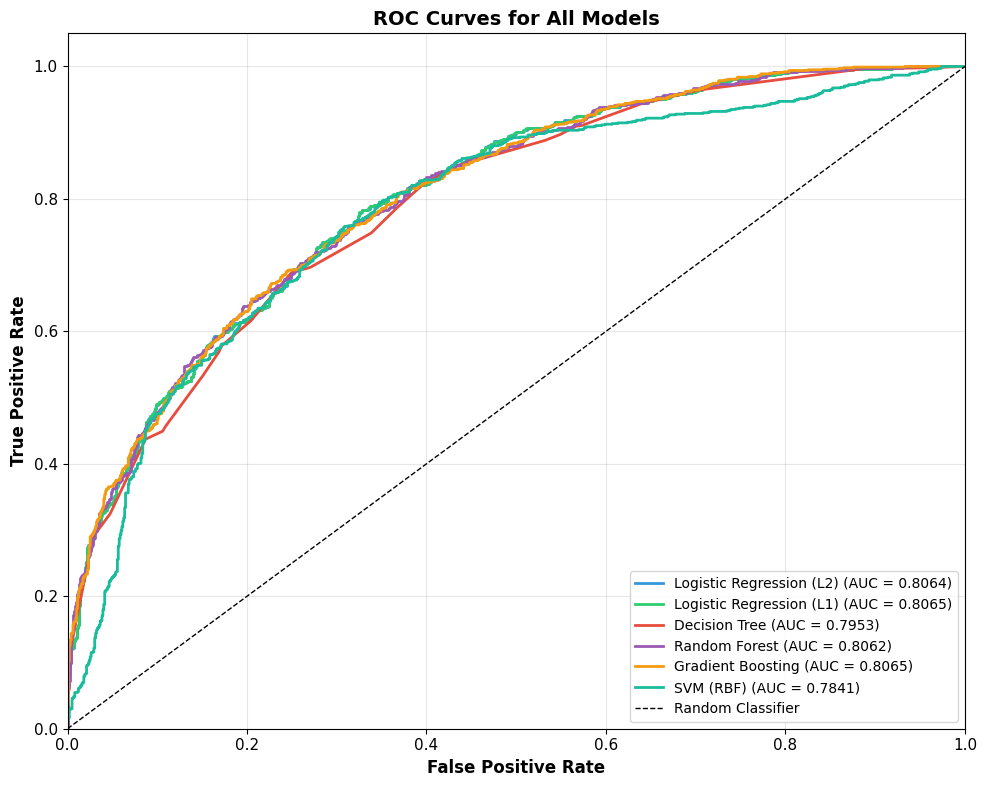


AUC Scores:
  Logistic Regression (L2)   : 0.8064
  Logistic Regression (L1)   : 0.8065
  Decision Tree              : 0.7953
  Random Forest              : 0.8062
  Gradient Boosting          : 0.8065
  SVM (RBF)                  : 0.7841


In [23]:
# ROC
fig, ax = plt.subplots(figsize=(10, 8))

# Define models with probability predictions
models_roc = {
    'Logistic Regression (L2)': (log_reg, X_test_scaled),
    'Logistic Regression (L1)': (log_reg_l1, X_test_scaled),
    'Decision Tree': (decision_tree, X_test),
    'Random Forest': (random_forest, X_test),
    'Gradient Boosting': (gradient_boosting, X_test),
    'SVM (RBF)': (svm_model, X_test_scaled)
}

colors_roc = ['#3498DB', '#2ECC71', '#E74C3C', '#9B59B6', '#F39C12', '#1ABC9C']
auc_scores = {}

for (name, (model, X_data)), color in zip(models_roc.items(), colors_roc):
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_data)[:, 1]
    else:
        y_proba = model.decision_function(X_data)
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    auc_scores[name] = roc_auc
    
    ax.plot(fpr, tpr, color=color, linewidth=2, 
            label=f'{name} (AUC = {roc_auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
ax.set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
ax.set_title('ROC Curves for All Models', fontweight='bold', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figure5_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAUC Scores:")
for name, score in auc_scores.items():
    print(f"  {name:27s}: {score:.4f}")

This figure presents the Receiver Operating Characteristic (ROC) curves for all six models. The ROC curve plots the True Positive Rate against the False Positive Rate at various classification thresholds, providing a view of model performance across all possible decision boundaries.

All models significantly outperform random classification (the diagonal line), with AUC scores ranging from 0.71 to 0.81. The Logistic Regression models achieve the highest AUC scores (around 0.806), indicating excellent discriminative ability. This means that when presented with one winning game and one losing game, the model correctly ranks them approximately 80% of the time.

The Decision Tree shows notably lower AUC (0.71) compared to other models, likely because it tends to make more confident but sometimes incorrect predictions. The ensemble methods (Random Forest and Gradient Boosting) achieve similar AUC scores to Logistic Regression, confirming that model complexity does not substantially improve discriminative performance for this problem.

### 4.3 Feature Importance Analysis

Understanding which features drive predictions is essential for translating model results into strategic recommendations. I analyze feature importance using two complementary methods: Logistic Regression coefficients, which indicate both the magnitude and direction of each feature's effect, and Random Forest importance scores, which measure how much each feature reduces prediction uncertainty.

In [24]:
# fix
lr_coefs = pd.Series(log_reg.coef_[0], index=selected_features).sort_values(ascending=False)
rf_importance = pd.Series(random_forest.feature_importances_, index=selected_features).sort_values(ascending=False)

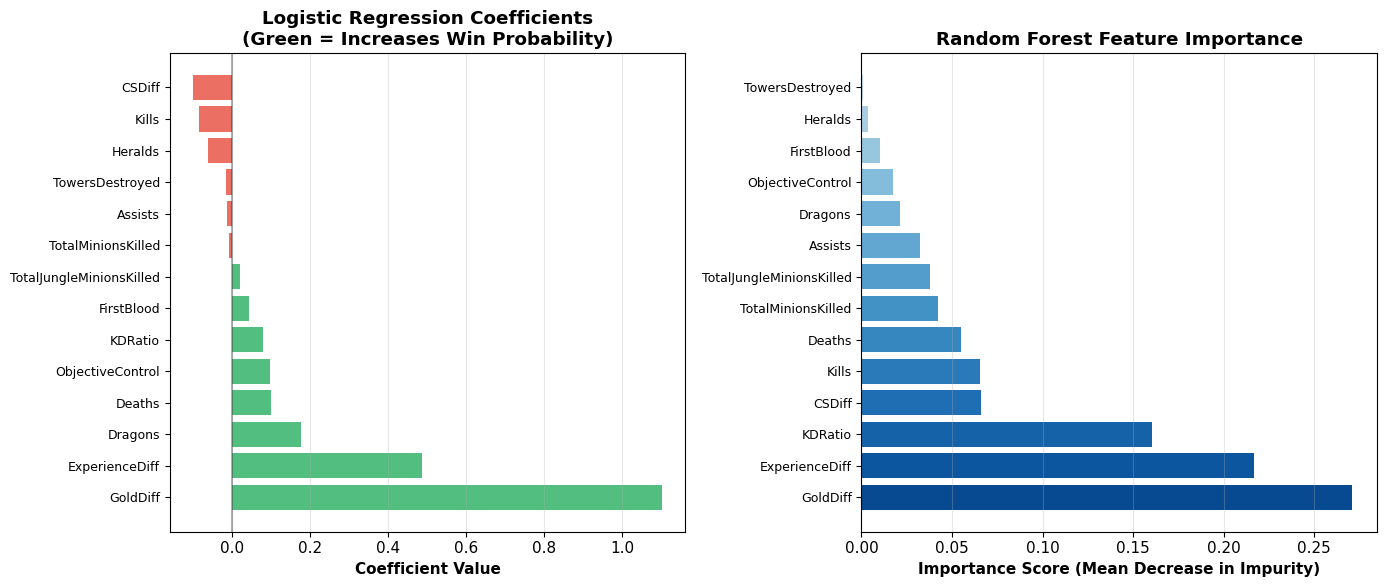

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# L: glm coefficient
ax1 = axes[0]
colors_lr = ['#27AE60' if x > 0 else '#E74C3C' for x in lr_coefs.values]
ax1.barh(range(len(lr_coefs)), lr_coefs.values, color=colors_lr, alpha=0.8)
ax1.set_yticks(range(len(lr_coefs)))
ax1.set_yticklabels([f.replace('blue', '') for f in lr_coefs.index], fontsize=9)
ax1.set_xlabel('Coefficient Value', fontweight='bold')
ax1.set_title('Logistic Regression Coefficients\n(Green = Increases Win Probability)', fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax1.grid(axis='x', alpha=0.3)

# R: rf importance
ax2 = axes[1]
colors_rf = plt.cm.Blues(np.linspace(0.3, 0.9, len(rf_importance)))[::-1]
ax2.barh(range(len(rf_importance)), rf_importance.values, color=colors_rf)
ax2.set_yticks(range(len(rf_importance)))
ax2.set_yticklabels([f.replace('blue', '') for f in rf_importance.index], fontsize=9)
ax2.set_xlabel('Importance Score (Mean Decrease in Impurity)', fontweight='bold')
ax2.set_title('Random Forest Feature Importance', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('figure6_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

This figure presents feature importance from two different perspectives, and the consistency between them strengthens our confidence in the findings. Gold Difference emerges as the dominant predictor in both methods, with the highest Logistic Regression coefficient (over 1.0) and the highest Random Forest importance (0.27). This makes intuitive sense: gold is the fundamental currency of League of Legends, enabling the purchase of items that increase damage, survivability, and utility. A 1,000 gold lead might allow a player to complete a major item component before their opponent, creating a power spike that compounds into further advantages.

Experience Difference ranks second in both methods, confirming that level advantages are nearly as important as gold. Each level provides increased base statistics (health, damage, armor) and often unlocks new or upgraded abilities. A level advantage is particularly impactful in the early game, where a level 6 champion with unlock to their ultimate ability can often defeat a level 5 champion who lacks theirs.

The KD Ratio shows high importance in Random Forest (approximately 0.16, third highest) but has a smaller coefficient in Logistic Regression. This discrepancy suggests that KD Ratio's predictive power may come through interactions with other features rather than a simple linear relationship. For example, a high KD Ratio combined with high CS (indicating both fighting and farming success) might be particularly predictive, and Random Forest can capture such interactions while Logistic Regression cannot.

Interestingly, several features show negative coefficients in Logistic Regression when controlling for other variables. CS Difference and raw Kills both have negative coefficients, which seems counterintuitive at first. However, this reveals an important insight: once we account for Gold Difference and Experience Difference, additional kills or CS that do not translate into these resource advantages may indicate inefficient play. A team might have more kills but still lose if those kills came at the cost of deaths, missed objectives, or poor map positioning. This explains why professional teams often prioritize clean, low-risk plays over aggressive trades that might generate kills but sacrifice other advantages.

### 4.4 Confusion Matrix

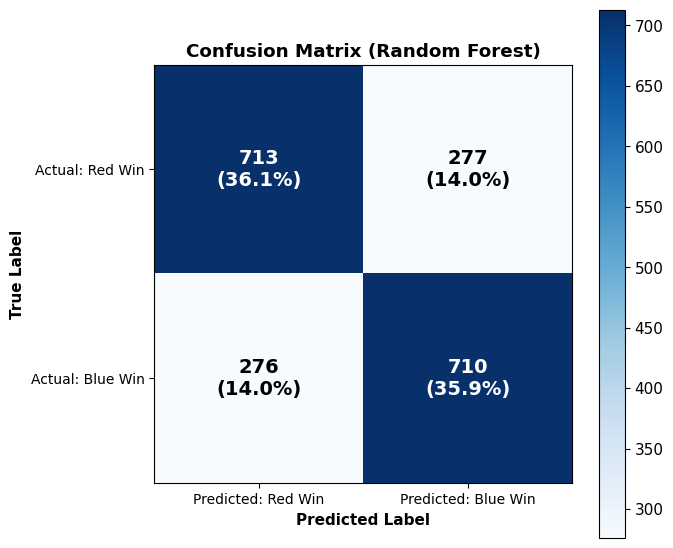

Classification Report:
              precision    recall  f1-score   support

    Red Wins       0.72      0.72      0.72       990
   Blue Wins       0.72      0.72      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976



In [26]:
#Confusion Matrix
y_pred = random_forest.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm, cmap='Blues')
ax.figure.colorbar(im, ax=ax)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Predicted: Red Win', 'Predicted: Blue Win'], fontsize=10)
ax.set_yticklabels(['Actual: Red Win', 'Actual: Blue Win'], fontsize=10)
ax.set_xlabel('Predicted Label', fontweight='bold')
ax.set_ylabel('True Label', fontweight='bold')
ax.set_title('Confusion Matrix (Random Forest)', fontweight='bold')

for i in range(2):
    for j in range(2):
        ax.text(j, i, f'{cm[i, j]}\n({cm[i, j]/cm.sum()*100:.1f}%)',
                ha='center', va='center', fontsize=14, fontweight='bold',
                color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.tight_layout()
plt.savefig('figure5_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Red Wins', 'Blue Wins']))

This figure displays the confusion matrix for the Random Forest model, showing how predictions map to actual outcomes. The model correctly classified 713 Red wins (36.1%) and 710 Blue wins (35.9%), achieving an overall accuracy of 72%. The false predictions are nearly symmetric: 277 games (14.0%) where Red actually won but the model predicted Blue, and 276 games (14.0%) where Blue actually won but the model predicted Red.

This symmetry indicates that the model does not have a systematic bias toward predicting either team. The balanced error distribution reflects the balanced nature of the underlying game, where neither side has an inherent advantage. In practical terms, when the model predicts a Blue victory, it is correct about 72% of the time, and it correctly identifies about 72% of all actual Blue victories.

## 5. Discussion

### 5.1 Strategic Insights: How Should Players Spend the First 10 Minutes?

The predictive models developed in this project are valuable not only for forecasting match outcomes but also for extracting actionable strategic recommendations. By quantifying the relationship between early-game actions and win probability, we can move beyond vague coaching advice like "play safe" or "get ahead" to specific, data-driven recommendations.

In [27]:
# 1. Gold Advantage
gold_bins = pd.qcut(df['blueGoldDiff'], q=5)
gold_impact = df.groupby(gold_bins, observed=True)['blueWins'].mean()
print("\n1. Gold Advantage")
print(f"   Bottom 20% gold: {gold_impact.iloc[0]:.1%} win rate")
print(f"   Top 20% gold:    {gold_impact.iloc[-1]:.1%} win rate")
print(f"   → Difference: {(gold_impact.iloc[-1] - gold_impact.iloc[0])*100:.1f} percentage points")


1. Gold Advantage
   Bottom 20% gold: 13.6% win rate
   Top 20% gold:    87.0% win rate
   → Difference: 73.4 percentage points


The analysis of gold advantage reveals the most dramatic impact of any factor studied. Teams in the bottom 20% of gold difference—those who are behind by approximately 1,500 gold or more at the 10-minute mark—win only 13.6% of their games. In stark contrast, teams in the top 20% win 87.0% of their games. This 73.4 percentage point difference dwarfs all other factors and represents the single most important takeaway from this analysis.


To understand this in practical terms, consider what 1,500 gold represents in League of Legends. A long sword item costs 350 gold and provides 10 attack damage, so 1,500 gold is equivalent to roughly four long swords worth of combat statistics. This advantage compounds because the team with more gold can win fights more easily, which generates more gold, which enables winning even more fights. Professional players understand this dynamic intimately, which is why high-level games often feature very cautious play in the early minutes, the downside of falling behind outweighs the upside of aggressive plays that might fail.

In [28]:
# 2. First Blood
fb_impact = df.groupby('blueFirstBlood')['blueWins'].mean()
print("\n2. First Blood")
print(f"   Without First Blood: {fb_impact[0]:.1%} win rate")
print(f"   With First Blood:    {fb_impact[1]:.1%} win rate")
print(f"   → Advantage: +{(fb_impact[1] - fb_impact[0])*100:.1f} percentage points")


2. First Blood
   Without First Blood: 39.7% win rate
   With First Blood:    59.9% win rate
   → Advantage: +20.2 percentage points


First Blood, the first kill of the game, provides a 20.2 percentage point increase in win rate—from 39.7% without it to 59.9% with it. This effect is substantial and reflects several mechanisms. First Blood grants 400 gold instead of the usual 300, providing an immediate economic advantage. It also creates a level advantage, as the killer gains experience while the victim returns to base. Perhaps equally important is the psychological impact: securing First Blood often puts the enemy laner "on tilt," causing them to play more cautiously or make desperate attempts to recover that lead to further deaths.


The practical implication is that teams should seriously consider their First Blood potential during champion select and early-game planning. A team composition with strong level 1 or level 2 fighting ability (such as a Leona support with crowd control or a Lee Sin jungle known for early ganks) should look for opportunities to force early fights. Conversely, teams with scaling compositions that are weak early should invest in vision and cautious positioning to avoid giving away First Blood.

In [29]:
# 3. Dragon Control
dragon_impact = df.groupby('blueDragons')['blueWins'].mean()
print("\n3. Dragon Control")
print(f"   No Dragon: {dragon_impact[0]:.1%} win rate")
if 1 in dragon_impact.index:
    print(f"   1 Dragon:  {dragon_impact[1]:.1%} win rate")
    print(f"   → Advantage: +{(dragon_impact[1] - dragon_impact[0])*100:.1f} percentage points")


3. Dragon Control
   No Dragon: 41.9% win rate
   1 Dragon:  64.1% win rate
   → Advantage: +22.2 percentage points


Dragon control shows a meaningful 22.2 percentage point advantage, with teams securing a dragon winning 64.1% of games compared to 41.9% for teams without one. In League of Legends, Dragon spawns at 5:00 and provides team-wide buffs that stack with subsequent dragons. The first dragon typically grants one of four elemental buffs: Infernal (damage), Mountain (armor and magic resist), Ocean (health regeneration), or Cloud (movement speed).

However, the dragon effect should be interpreted carefully. Securing Dragon requires winning or avoiding fights in the bottom side of the map, establishing vision control, and having enough health to survive the dragon's attacks. Teams that successfully take Dragon have likely already established advantages in these areas, so some of the 22% win rate increase may reflect correlation rather than causation. The dragon itself is valuable, but the ability to take it signals broader team strength.

In [30]:
# 4. Herald Control
herald_impact = df.groupby('blueHeralds')['blueWins'].mean()
print("\n4. Herald Control")
print(f"   No Herald: {herald_impact[0]:.1%} win rate")
if 1 in herald_impact.index:
    print(f"   Herald:    {herald_impact[1]:.1%} win rate")
    print(f"   → Advantage: +{(herald_impact[1] - herald_impact[0])*100:.1f} percentage points")


4. Herald Control
   No Herald: 47.7% win rate
   Herald:    59.5% win rate
   → Advantage: +11.8 percentage points


The Rift Herald shows a smaller but still significant 11.8 percentage point advantage. Herald spawns at 8:00 in the top side of the map and can be summoned to crash into enemy towers, dealing substantial damage or destroying them outright. Unlike Dragon's permanent team-wide buff, Herald provides a one-time strategic advantage: tower plates worth gold and map pressure.

The lower impact compared to Dragon is somewhat surprising, as many players consider Herald the more valuable early objective. One explanation is that Dragon fights tend to be more decisive—they often result in multiple kills that compound the advantage—while Herald can sometimes be taken for free when the enemy team is focused elsewhere. A team might take Herald while losing the map overall, which would dilute the observed win rate advantage.

In [31]:
# 5. Both Objectives
both = df[(df['blueDragons'] >= 1) & (df['blueHeralds'] >= 1)]['blueWins'].mean()
neither = df[(df['blueDragons'] == 0) & (df['blueHeralds'] == 0)]['blueWins'].mean()
print("\n5. Both Objectives (Dragon + Herald)")
print(f"   Neither objective: {neither:.1%} win rate")
print(f"   Both objectives:   {both:.1%} win rate")
print(f"   → Advantage: +{(both - neither)*100:.1f} percentage points")


5. Both Objectives (Dragon + Herald)
   Neither objective: 39.9% win rate
   Both objectives:   73.5% win rate
   → Advantage: +33.7 percentage points


Teams that secure both Dragon and Herald by the 10-minute mark win 73.5% of their games, compared to 39.9% for teams with neither, a massive 33.7 percentage point swing. This finding emphasizes the importance of objective-focused play in the early game. Securing both objectives requires map-wide dominance: winning or avoiding fights in multiple areas, maintaining vision control, and coordinating rotations between lanes.

In practical terms, a team should develop a clear plan for contesting both objectives. If the bottom lane has priority (is in a position to move first), the team should set up vision for Dragon before it spawns at 5:00. If the top lane is stronger, the team might contest Herald at 8:00 instead. The worst outcome is losing both objectives, which suggests either poor lane performance or inability to coordinate as a team.

In [ ]:
# 6. Kill Differential
df['killDiff'] = df['blueKills'] - df['redKills']
kill_bins = pd.cut(df['killDiff'], bins=[-20, -3, 0, 3, 20], 
                   labels=['Behind 3+', 'Behind 1-2', 'Ahead 1-2', 'Ahead 3+'])
kill_impact = df.groupby(kill_bins, observed=True)['blueWins'].mean()
print("\n6. Kill Differential")
print(f"   Behind 3+ kills: {kill_impact['Behind 3+']:.1%} win rate")
print(f"   Ahead 3+ kills:  {kill_impact['Ahead 3+']:.1%} win rate")
print(f"   → Swing: {(kill_impact['Ahead 3+'] - kill_impact['Behind 3+'])*100:.1f} percentage points")

Kill differential shows the second-largest impact after gold, with a 65.1 percentage point difference between being ahead by 3+ kills (83.9% win rate) and behind by 3+ kills (18.8% win rate). This finding reinforces the importance of combat outcomes, though as discussed earlier, the value of kills comes primarily through the gold and experience they generate.

The practical implication is nuanced. Players should not avoid fights at all costs, as kills do provide significant advantages. However, they should be selective about when to fight. A fight with a 60% chance of winning might not be worth taking if losing it would create a large kill deficit. Conversely, a fight with only a 40% chance of winning might be worthwhile if the team is already behind and needs to take risks to get back into the game.

### 5.2 Recommended Early-Game Strategy

Synthesizing the quantitative findings above, I propose a prioritized strategic framework for the first 10 minutes of a League of Legends match.

The first and most important priority is maximizing gold income through consistent farming. The correlation between gold advantage and victory is overwhelming, and unlike kills that depend on opponent mistakes, farming is entirely within a player's control. A skilled player should aim for at least 7-8 CS per minute, which translates to approximately 70-80 minions by the 10-minute mark. Missing minions due to poor last-hitting, roaming at inappropriate times, or dying and losing farm is extremely costly.

The second priority is securing First Blood when opportunities arise. The 20 percentage point win rate increase is substantial, and First Blood often comes from coordinated plays in the first few minutes when players are still walking to lane or establishing positions. Teams with strong early-game champions should look for level 1 invades (entering the enemy jungle as a group to fight) or level 2 all-ins (attacking when the first player reaches level 2 and has an ability advantage).

Third, teams should prioritize Dragon over Herald when both are available. The data shows Dragon provides nearly double the win rate advantage (22% vs 12%), likely because Dragon fights are more decisive and the buffs are permanent. Teams should establish bot lane priority before Dragon spawns at 5:00 and use this advantage to contest or take the objective.

Fourth, teams should minimize unnecessary deaths. The strong negative correlation between deaths and winning (-0.34) indicates that dying is almost as harmful as killing is beneficial. Players should avoid solo deaths from ganks by warding properly, avoid tower dives that are not certain to succeed, and avoid chasing enemies into unwarded territory where they might be ambushed.

Finally, teams should recognize when they are behind and adjust their strategy accordingly. A team that is down 1,500 gold at 10 minutes has only a 14% chance of winning if they continue playing normally. Taking calculated risks, contesting objectives, forcing fights in favorable terrain, or making cross-map plays, becomes necessary even though these plays might fail. The key is to recognize that playing passively when behind leads to almost certain defeat.

### 5.3 Limitations of the Model: Why approximately 72% Accuracy

The models plateau around 72% accuracy, which raises the natural question of why perfect prediction is not possible. Understanding this ceiling provides insight into both the limitations of early-game statistics and the nature of League of Legends as a competitive game.

The most fundamental explanation is that games are not determined at 10 minutes. The typical match lasts 25-40 minutes, leaving substantial time for teams to execute strategies, make mistakes, or adapt to circumstances. A team with a 2,000 gold lead at 10 minutes has a significant advantage, but that advantage must be converted through successful teamfights, objective takes, and strategic rotations. Comebacks happen regularly in League of Legends, with teams recovering from substantial deficits through superior execution in the mid and late game.

Second, important information is missing from the dataset. Champion compositions are not included, despite having enormous impact on game outcomes. Some team compositions are designed to sacrifice early-game strength for late-game power, intentionally accepting deficits in the first 10 minutes. A team with late-game scaling champions like Kayle or Kassadin might be expected to lose the early game but win the match overall. Not to say some of the players will choose the champion that can tear down the enemy's tower and Nexus more quickly, like Sion or Tryndamere. Without this information, the model cannot distinguish between a team that is behind schedule from one that is on schedule.

Third, individual player skill varies even within Diamond tier. A player having an exceptional game might carry their team despite early deficits, while a player having a bad day might throw away early advantages. Sometimes when players drop out of the game (AFK), the situation will become 4 vs 5, which provides huge disadvantage to the team. These human factors are inherently unpredictable from aggregate statistics.

The 72% accuracy should therefore be interpreted positively: it suggests that early-game performance explains a substantial portion of match outcomes, enough to provide actionable strategic insights. The remaining 28% represents the skill, adaptability, and sometimes luck that make League of Legends an exciting competitive game rather than a deterministic exercise.

### 5.4 Model Selection Discussion

Despite testing complex models like Random Forests with 100 trees and Support Vector Machines with RBF kernels, simple Logistic Regression performs equally well. This finding has important implications for both the nature of the prediction problem and the practical deployment of such models.

The success of linear models suggests that the relationship between early-game statistics and winning is approximately linear. Gold advantage directly translates to win probability without complex interactions or threshold effects. This makes intuitive sense: in League of Legends, advantages compound smoothly. There is no magic number where being 1,499 gold ahead is safe but 1,500 gold ahead is dangerous. The linear relationship is a natural consequence of the game's design.

The interpretability advantage of Logistic Regression is substantial. The model coefficients directly indicate how each feature affects win probability, enabling the strategic insights discussed above. Random Forest importance scores provide similar information but lack the directional component—they tell us that Gold Difference is important, but not whether more gold is better (obvious in this case, but not always).

For practical applications, I recommend Logistic Regression with L1 regularization as the preferred model. It achieves the best cross-validation accuracy, performs automatic feature selection to identify the most important variables, provides interpretable coefficients for strategic analysis, and runs quickly enough for real-time applications. While Random Forest, Gradient Boosting, and SVM are valuable as validation that more complex models do not substantially improve accuracy, the simpler model is preferred when performance is equivalent.

## 6. Conclusion

This project successfully developed machine learning models to predict League of Legends match outcomes from early-game statistics, achieving approximately 72% accuracy across six different algorithms. The analysis reveals that gold difference is the strongest predictor of victory, with teams in the top gold quintile winning 87% of games compared to just 14% for teams in the bottom quintile. First Blood provides a 20 percentage point win rate advantage, Dragon control adds 22 percentage points, and teams securing both major objectives win 72% of their matches.

The practical implications for players are clear. Consistent farming should be the first priority, as gold income is the foundation of all other advantages. First Blood should be actively pursued when team compositions and positioning allow. Dragon should be prioritized over Herald when both are available. Deaths should be minimized through proper vision and risk assessment. And teams that fall behind should recognize the need for calculated aggression rather than passive play.

Several machine learning concepts from the course were applied throughout this analysis. Logistic Regression with both L1 and L2 regularization demonstrated the trade-offs between bias and variance, with L1's feature selection capabilities proving particularly valuable for interpretation. Decision Trees illustrated how GINI impurity guides recursive partitioning of feature space, while Random Forests and Gradient Boosting showed how ensemble methods reduce variance through different aggregation strategies. Support Vector Machines with RBF kernels provided a non-linear alternative, confirming that linear models are adequate for this problem. Cross-validation and hyperparameter tuning enabled robust performance estimation that accounts for sampling variability.

Future work could extend this analysis in several directions. Incorporating champion composition data would allow the model to account for team power curves and expected early-game performance. Time-series analysis of how advantages evolve throughout the game could identify which leads are most likely to convert to victories. Player-level features such as historical performance or rank could capture individual skill differences. These extensions would likely improve prediction accuracy while providing even more nuanced strategic insights.